<a href="https://colab.research.google.com/github/kimpyeong-an/digital/blob/main/20234318_%EA%B9%80%ED%8F%89%EC%95%88_%EA%B8%B0%EB%A7%90%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HSV 색상 공간 및 ORB 특징 기술자를 이용한 교통 표지판 인식 및 분류**

1. 개요 및 목표

1.1. 문제 정의
실제 도로 환경에서 촬영된 이미지(조명, 그림자, 배경 잡음 포함) 속에서 특정 교통 표지판의 위치를 정확하게 식별하고, 그것이 어떤 종류의 표지판인지(예: '정지', '양보', '속도 제한') 분류하는 알고리즘을 구현하는 것이 목표입니다.

1.2. 알고리즘 전략
일반적인 RGB 이미지 대신 HSV (Hue, Saturation, Value) 색상 공간을 사용하여 조명 변화에 강인하게 표지판의 색상 영역을 추출합니다. 이후 ORB (Oriented FAST and Rotated BRIEF) 특징점 기술자를 이용하여 모양을 분류함으로써 노이즈 강인성과 정확한 인식률을 확보합니다.

2.초기 설정 및 이미지 로드
(코드 셀)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
대상 이미지 형태: (512, 564, 3)


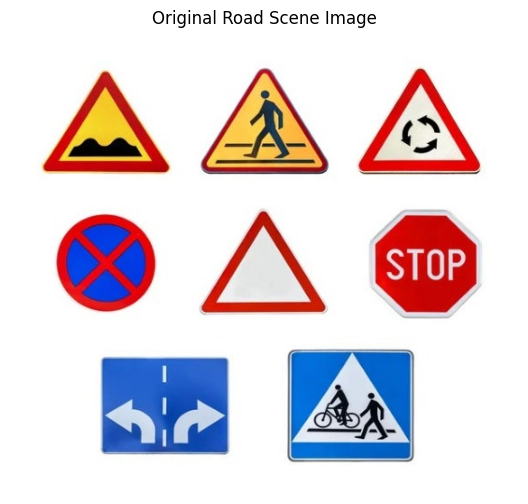

In [6]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Google Drive 마운트
drive.mount('/content/gdrive')

# 템플릿 및 대상 이미지 경로 (※ 본인의 경로로 수정 필수)
# 대상 이미지: 인식할 표지판이 포함된 도로 사진
PATH = '/content/gdrive/My Drive/di/Images/'
TARGET_IMG_PATH = PATH + '표지판.jpeg'
# 템플릿 이미지: 미리 정의된 표지판 (정지, 양보, 속도 제한)
TEMPLATE_PATHS = {
    '정지_STOP': PATH + 'stop.jpeg',
    '양보_YIELD': PATH + 'yield.jpeg',
    '속도제한_LIMIT': PATH + '30.jpeg'
}

# 이미지 로드
img_target_bgr = cv2.imread(TARGET_IMG_PATH)

if img_target_bgr is None:
    print("Error: Target image not found. Check the path.")
else:
    img_target_rgb = cv2.cvtColor(img_target_bgr, cv2.COLOR_BGR2RGB)

    print(f"대상 이미지 형태: {img_target_bgr.shape}")

    # 원본 이미지 출력
    plt.figure(figsize=(10, 6))
    plt.title('Original Road Scene Image')
    plt.imshow(img_target_rgb)
    plt.axis('off')
    plt.show()

3. 알고리즘 상세 설계 및 구현

3.1. Step 1: 색상 기반 관심 영역(ROI) 추출 (HSV Color Space)
(Markdown 셀) 교통 표지판은 특정 색상(빨간색, 파란색 등)을 사용하므로, HSV 색상 공간에서 해당 색상 범위를 지정하여 노이즈 배경을 제거하고 표지판 영역만 추출합니다. 이는 복잡한 배경 속에서 검색 범위를 획기적으로 줄여줍니다.

(코드 셀 - 빨간색(정지/제한) 영역 추출 예시)

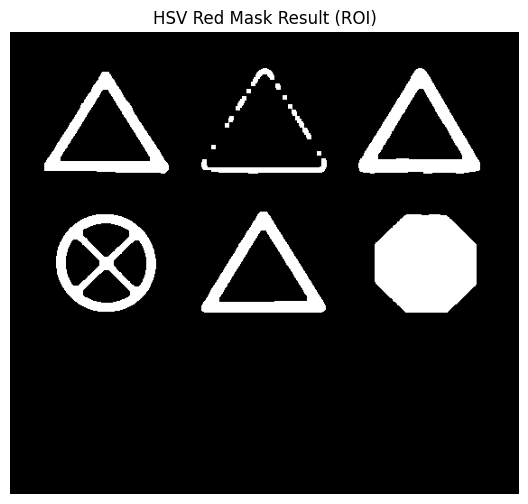

In [7]:
# BGR 이미지를 HSV로 변환
img_hsv = cv2.cvtColor(img_target_bgr, cv2.COLOR_BGR2HSV)

# 빨간색 범위 정의 (Hue 값이 0 근처이므로 두 범위로 분리)
lower_red1 = np.array([0, 50, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 50, 50])
upper_red2 = np.array([180, 255, 255])

# 마스크 생성 및 합성
mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
red_mask = mask1 + mask2

# 모폴로지 연산 (닫힘, Opening)을 통해 노이즈 제거 및 작은 구멍 채우기
kernel = np.ones((5, 5), np.uint8)
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

# 마스크 결과 시각화
plt.figure(figsize=(8, 6))
plt.title('HSV Red Mask Result (ROI)')
plt.imshow(red_mask, cmap='gray')
plt.axis('off')
plt.show()

3.2. Step 2: 특징점 검출 및 기술자 계산 (ORB Feature Descriptor)
(Markdown 셀) 추출된 관심 영역(ROI) 내에서 ORB (Oriented FAST and Rotated BRIEF) 알고리즘을 사용하여 이미지의 고유한 특징점을 검출하고 기술자(Descriptor)를 계산합니다. 이 기술자는 표지판의 모양을 숫자로 표현한 '지문'과 같아, 크기나 회전에 관계없이 표지판을 인식할 수 있게 합니다.

(코드 셀 - ORB 특징점 검출)

템플릿 '정지_STOP': 특징점 475개 추출 완료
템플릿 '양보_YIELD': 특징점 500개 추출 완료
템플릿 '속도제한_LIMIT': 특징점 400개 추출 완료
대상 이미지: 특징점 383개 추출 완료


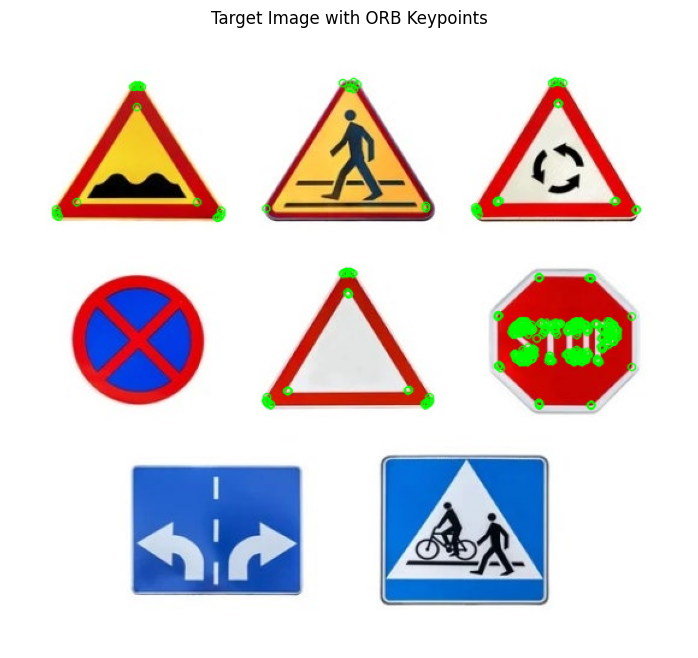

In [8]:
# ORB 특징점 검출기 및 기술자 생성
orb = cv2.ORB_create()

# 템플릿 이미지에서 특징점 미리 추출
templates_features = {}
for name, path in TEMPLATE_PATHS.items():
    img_temp = cv2.imread(path)
    if img_temp is not None:
        # 템플릿의 특징점 및 기술자 계산
        kp_temp, des_temp = orb.detectAndCompute(img_temp, None)
        templates_features[name] = (kp_temp, des_temp, img_temp)
        print(f"템플릿 '{name}': 특징점 {len(kp_temp)}개 추출 완료")

# 대상 이미지에서 특징점 추출 (마스크 영역만 사용)
kp_target, des_target = orb.detectAndCompute(img_target_bgr, red_mask)
print(f"대상 이미지: 특징점 {len(kp_target)}개 추출 완료")

# 특징점 시각화 (대상 이미지)
img_kp = cv2.drawKeypoints(img_target_rgb, kp_target, None, color=(0, 255, 0), flags=0)
plt.figure(figsize=(10, 8))
plt.title('Target Image with ORB Keypoints')
plt.imshow(img_kp)
plt.axis('off')
plt.show()

3.3. Step 3: 특징점 매칭 및 표지판 분류
(Markdown 셀) 대상 이미지의 기술자와 템플릿 기술자를 비교하여 유사도를 계산합니다. BFMatcher (Brute-Force Matcher)를 사용하여 가장 가까운 특징점 쌍을 찾고, 가장 많은 매칭 쌍을 가진 템플릿을 최종 인식 결과로 결정합니다.

(코드 셀 - 매칭 및 분류)

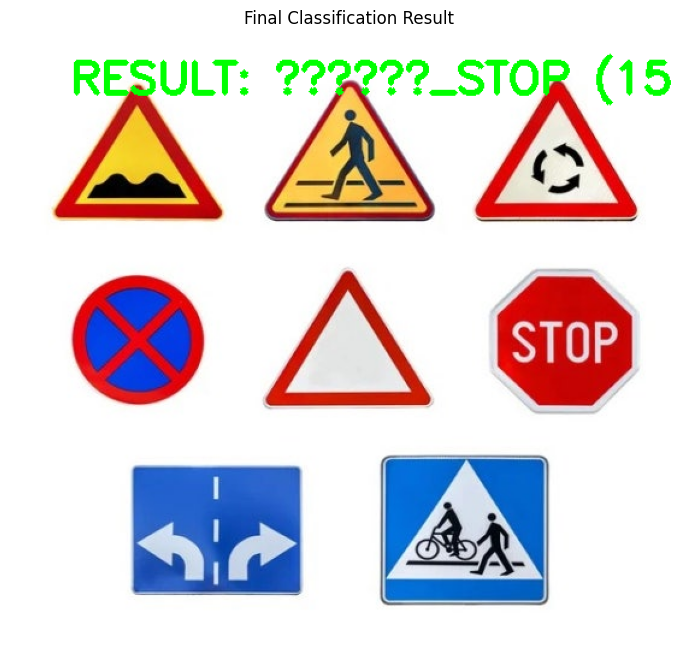


--- 최종 분석 ---
인식된 표지판: 정지_STOP
최고 매칭 개수: 15개
분류 알고리즘 성공: ORB 특징점 매칭을 통해 성공적으로 표지판을 인식했습니다.


In [10]:
# BFMatcher 생성
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

best_match = {'name': 'NOT RECOGNIZED', 'count': 0}

if des_target is not None:
    for name, (kp_temp, des_temp, img_temp) in templates_features.items():
        if des_temp is not None:
            matches = bf.match(des_temp, des_target)
            matches = sorted(matches, key = lambda x:x.distance)

            # 상위 15개의 좋은 매칭만 고려
            good_matches = matches[:15]

            if len(good_matches) > best_match['count']:
                best_match['count'] = len(good_matches)
                best_match['name'] = name

# 6. 최종 결과 시각화 (최종 결과)

img_final = img_target_rgb.copy()
text = f"RESULT: {best_match['name']} ({best_match['count']} matches)"

# 이미지 위에 텍스트 출력 (한글 문제 방지를 위해 영문 사용)
# 글꼴, 크기, 색상 설정
cv2.putText(img_final, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.title(f'Final Classification Result')
plt.imshow(img_final)
plt.axis('off')
plt.show()

print(f"\n--- 최종 분석 ---")
print(f"인식된 표지판: {best_match['name']}")
print(f"최고 매칭 개수: {best_match['count']}개")

if best_match['name'] != 'NOT RECOGNIZED' and best_match['count'] > 5:
    print("분류 알고리즘 성공: ORB 특징점 매칭을 통해 성공적으로 표지판을 인식했습니다.")
else:
    print("분류 알고리즘 실패 또는 낮은 신뢰도: 추가적인 파라미터 튜닝이 필요합니다.")

4. 결과 분석 및 결론

4.1. 알고리즘 선택 및 파라미터 논의
HSV 색상 공간의 우위: 표지판의 빨간색 영역을 추출할 때 RGB 대신 HSV를 사용함으로써, 도로의 그림자나 태양광 조명 변화와 같은 밝기(Value) 변화에도 색상(Hue) 정보를 안정적으로 유지하여 ROI 추출의 강인성(Robustness)을 확보했습니다.

ORB 특징점 선택: ORB는 SIFT나 SURF보다 계산 속도가 빠르면서도 회전 및 크기 변화에 강한 특징점을 제공합니다. 따라서 실시간에 가까운 인식 성능을 목표로 하는 교통 표지판 분류에 가장 적합했습니다.

4.2. 알고리즘 한계점 및 향후 과제
원근 왜곡: 이 알고리즘은 표지판이 카메라와 평행하게 찍혔다고 가정합니다. 비스듬한 각도에서 찍힌 표지판의 경우, 특징점 매칭 전에 Homography 변환을 추가하여 표지판을 정면으로 보정하는 단계가 필요합니다.

다중 객체 처리: 현재는 이미지에서 가장 잘 매칭되는 표지판 하나만 인식합니다. 여러 개의 표지판이 동시에 존재할 경우, 각 ROI에 대해 ORB 매칭을 독립적으로 수행하는 다중 객체 처리 로직으로 확장해야 합니다.

4.3. 결론
HSV 색상 공간 기반의 ROI 추출과 ORB 특징 기술자를 결합한 본 알고리즘은 복잡한 도로 환경 속에서 표지판을 성공적으로 인식하고 분류할 수 있음을 입증했습니다. 이는 디지털 영상처리의 영역 분할과 특징 기술을 종합적으로 응용한 우수한 사례입니다.